## Load snli train and val data

In [2]:
import pandas as pd

# load snli train data
snli_train = pd.read_csv("snli_train.tsv", sep='\t')
snli_train.loc[snli_train['label'] == 'neutral', 'y'] = 0
snli_train.loc[snli_train['label'] == 'entailment', 'y'] = 1
snli_train.loc[snli_train['label'] == 'contradiction', 'y'] = 2
train_s1 = snli_train['sentence1'].tolist()
train_s2 = snli_train['sentence2'].tolist()
train_label = snli_train['y'].tolist()

# load snli validation data
snli_val = pd.read_csv("snli_val.tsv", sep='\t')
snli_val.loc[snli_val['label'] == 'neutral', 'y'] = 0
snli_val.loc[snli_val['label'] == 'entailment', 'y'] = 1
snli_val.loc[snli_val['label'] == 'contradiction', 'y'] = 2
val_s1 = snli_val['sentence1'].tolist()
val_s2 = snli_val['sentence2'].tolist()
val_label = snli_val['y'].tolist()

## Load the FastText embedding matrix and get the indices data

In [3]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 128

In [5]:
# loading Fast text vectors
ft_home = './'
words_to_load = 50000

import numpy as np

with open(ft_home + 'wiki-news-300d-1M.vec') as f:
    loaded_embeddings = np.zeros((words_to_load + 1, 300))
    words2idx = {}
    idx2words = {}
    ordered_words = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings[i + 1, :] = np.asarray(s[1:])
        words2idx[s[0]] = i + 1
        idx2words[i+1] = s[0]
        ordered_words.append(s[0])
        
idx2words[PAD_IDX] = '<pad>'
idx2words[UNK_IDX] = '<unk>'
words2idx['<pad>'] = PAD_IDX
words2idx['<unk>'] = UNK_IDX
# make a random vector for the unknown, and a zero vector for the padding
loaded_embeddings[PAD_IDX] = torch.zeros(300)
loaded_embeddings[UNK_IDX] = torch.randn(300)
pre_emb = torch.from_numpy(loaded_embeddings)
pre_emb = pre_emb.float()

In [6]:
# convert token to id in the dataset
def token2index_dataset(tokens_dataset):
    indices_data = []
    for tokens_data in tokens_dataset:
        tokens = tokens_data.split()
        index_list = [words2idx[token] if token in words2idx else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_s1_idx = token2index_dataset(train_s1)
train_s2_idx = token2index_dataset(train_s2)
val_s1_idx = token2index_dataset(val_s1)
val_s2_idx = token2index_dataset(val_s2)

## Process the data with data loader

In [7]:
MAX_SENTENCE_LENGTH = max([len(s) for s in train_s1_idx + train_s2_idx])

class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_list, target_list):
        """
        @param data_list: list of tokens
        @param target_list: list of targets

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        
        """
        s1 = self.data_list[key][0][:MAX_SENTENCE_LENGTH]
        s2 = self.data_list[key][1][:MAX_SENTENCE_LENGTH]
        l1 = len(s1)
        l2 = len(s2)
        label = self.target_list[key]
        return [[s1, s2], [l1, l2], label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []

    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_s1 = np.pad(np.array(datum[0][0]),
                            pad_width=((0,MAX_SENTENCE_LENGTH-datum[1][0])),
                            mode="constant", constant_values=0)
        padded_s2 = np.pad(np.array(datum[0][1]),
                            pad_width=((0,MAX_SENTENCE_LENGTH-datum[1][1])),
                            mode="constant", constant_values=0)
        padded_vec = [padded_s1, padded_s2]
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


In [8]:
train_data = np.array([train_s1_idx, train_s2_idx]).transpose()
val_data = np.array([val_s1_idx, val_s2_idx]).transpose()

train_dataset = VocabDataset(train_data, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=vocab_collate_func, 
                                           shuffle=True)
val_dataset = VocabDataset(val_data, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         collate_fn=vocab_collate_func, 
                                         shuffle=True)

## Encode the data with RNN

In [9]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight = nn.Parameter(pre_emb)
        self.embedding.weight.requires_grad = False
        
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.fc1 = nn.Linear(4 * hidden_size, 2 * hidden_size)
        self.fc2 = nn.Linear(2 * hidden_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(2 * self.num_layers, batch_size, self.hidden_size)

        return hidden

    def forward(self, data, lengths):
        
        s1 = data.transpose(0,1)[0]
        s2 = data.transpose(0,1)[1]
        
        l1 = lengths.transpose(0,1)[0]  
        l2 = lengths.transpose(0,1)[1]  
        
        l1, arg1 = l1.sort(descending=True)
        l2, arg2 = l2.sort(descending=True)
        
        s1 = s1[arg1]
        s2 = s2[arg2]
        
        batch_size, seq_len = s1.size()
        
        self.hidden = self.init_hidden(batch_size)
        embed1 = self.embedding(s1)
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, l1.numpy(), batch_first=True)
        rnn_out1, self.hidden = self.gru(embed1, self.hidden)      
        rnn_out1, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out1, batch_first=True)
        rnn_out1 = torch.sum(rnn_out1, dim=1)
        arg1 = np.argsort(arg1)
        rnn_out1 = rnn_out1[arg1]
        
        self.hidden = self.init_hidden(batch_size)
        embed2 = self.embedding(s2)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, l2.numpy(), batch_first=True)
        rnn_out2, self.hidden = self.gru(embed2, self.hidden)
        rnn_out2, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out2, batch_first=True)
        rnn_out2 = torch.sum(rnn_out2, dim=1)
        arg2 = np.argsort(arg2)
        rnn_out2 = rnn_out2[arg2]
        
        rnn_out = torch.cat((rnn_out1, rnn_out2), dim = 1)
        
        rnn_out = self.fc1(rnn_out)
        rnn_out = self.fc2(rnn_out)
        return rnn_out



In [10]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for (data, lengths, labels) in loader:
        
        outputs = F.softmax(model(data, lengths), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train_model(train_loader, val_loader, model):
    train_acc_list = []
    val_acc_list = []

    # Train the model
    for epoch in range(num_epochs):
        for i, (data, length, label) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data, length)
            loss = criterion(outputs, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                train_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Training Acc: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc))
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
    return train_acc_list, val_acc_list


In [11]:
model4 = RNN(emb_size=300, hidden_size=200, num_layers=1, num_classes=3, vocab_size=len(idx2words))

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=learning_rate)

train_acc4, val_acc4 = train_model(train_loader, val_loader, model4)

Epoch: [1/10], Step: [101/782], Training Acc: 40.077, Validation Acc: 40.0
Epoch: [1/10], Step: [201/782], Training Acc: 43.505, Validation Acc: 45.5
Epoch: [1/10], Step: [301/782], Training Acc: 46.905, Validation Acc: 46.6
Epoch: [1/10], Step: [401/782], Training Acc: 48.733, Validation Acc: 48.2
Epoch: [1/10], Step: [501/782], Training Acc: 50.351, Validation Acc: 49.4
Epoch: [1/10], Step: [601/782], Training Acc: 51.526, Validation Acc: 50.2
Epoch: [1/10], Step: [701/782], Training Acc: 52.636, Validation Acc: 54.4
Epoch: [2/10], Step: [101/782], Training Acc: 53.33, Validation Acc: 54.2
Epoch: [2/10], Step: [201/782], Training Acc: 53.718, Validation Acc: 53.1
Epoch: [2/10], Step: [301/782], Training Acc: 54.874, Validation Acc: 54.4
Epoch: [2/10], Step: [401/782], Training Acc: 54.9, Validation Acc: 52.7
Epoch: [2/10], Step: [501/782], Training Acc: 55.834, Validation Acc: 55.2
Epoch: [2/10], Step: [601/782], Training Acc: 55.392, Validation Acc: 56.7
Epoch: [2/10], Step: [701/78

In [12]:
model5 = RNN(emb_size=300, hidden_size=100, num_layers=1, num_classes=3, vocab_size=len(idx2words))

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=learning_rate)

train_acc5, val_acc5 = train_model(train_loader, val_loader, model5)

Epoch: [1/10], Step: [101/782], Training Acc: 41.036, Validation Acc: 37.7
Epoch: [1/10], Step: [201/782], Training Acc: 43.498, Validation Acc: 43.9
Epoch: [1/10], Step: [301/782], Training Acc: 47.107, Validation Acc: 44.6
Epoch: [1/10], Step: [401/782], Training Acc: 49.38, Validation Acc: 48.9
Epoch: [1/10], Step: [501/782], Training Acc: 51.201, Validation Acc: 50.0
Epoch: [1/10], Step: [601/782], Training Acc: 52.176, Validation Acc: 52.0
Epoch: [1/10], Step: [701/782], Training Acc: 52.968, Validation Acc: 52.4
Epoch: [2/10], Step: [101/782], Training Acc: 54.781, Validation Acc: 56.2
Epoch: [2/10], Step: [201/782], Training Acc: 55.31, Validation Acc: 54.2
Epoch: [2/10], Step: [301/782], Training Acc: 55.582, Validation Acc: 54.8
Epoch: [2/10], Step: [401/782], Training Acc: 55.784, Validation Acc: 54.2
Epoch: [2/10], Step: [501/782], Training Acc: 56.314, Validation Acc: 56.9
Epoch: [2/10], Step: [601/782], Training Acc: 56.471, Validation Acc: 56.4
Epoch: [2/10], Step: [701/7

In [13]:
class RNN2(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN2, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight = nn.Parameter(pre_emb)
        self.embedding.weight.requires_grad = False
        
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.fc1 = nn.Linear(2 * hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(2 * self.num_layers, batch_size, self.hidden_size)

        return hidden

    def forward(self, data, lengths):
        
        s1 = data.transpose(0,1)[0]
        s2 = data.transpose(0,1)[1]
        
        l1 = lengths.transpose(0,1)[0]  
        l2 = lengths.transpose(0,1)[1]  
        
        l1, arg1 = l1.sort(descending=True)
        l2, arg2 = l2.sort(descending=True)
        
        s1 = s1[arg1]
        s2 = s2[arg2]
        
        batch_size, seq_len = s1.size()
        
        self.hidden = self.init_hidden(batch_size)
        embed1 = self.embedding(s1)
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, l1.numpy(), batch_first=True)
        rnn_out1, self.hidden = self.gru(embed1, self.hidden)      
        rnn_out1, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out1, batch_first=True)
        rnn_out1 = torch.sum(rnn_out1, dim=1)
        arg1 = np.argsort(arg1)
        rnn_out1 = rnn_out1[arg1]
        
        self.hidden = self.init_hidden(batch_size)
        embed2 = self.embedding(s2)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, l2.numpy(), batch_first=True)
        rnn_out2, self.hidden = self.gru(embed2, self.hidden)
        rnn_out2, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out2, batch_first=True)
        rnn_out2 = torch.sum(rnn_out2, dim=1)
        arg2 = np.argsort(arg2)
        rnn_out2 = rnn_out2[arg2]
        
        rnn_out = rnn_out1 * rnn_out2
        
        rnn_out = self.fc1(rnn_out)
        rnn_out = self.fc2(rnn_out)
        return rnn_out


In [14]:
model6 = RNN2(emb_size=300, hidden_size=200, num_layers=1, num_classes=3, vocab_size=len(idx2words))

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model6.parameters(), lr=learning_rate)

train_acc6, val_acc6 = train_model(train_loader, val_loader, model6)

Epoch: [1/10], Step: [101/782], Training Acc: 34.903, Validation Acc: 34.5
Epoch: [1/10], Step: [201/782], Training Acc: 36.505, Validation Acc: 37.4
Epoch: [1/10], Step: [301/782], Training Acc: 36.998, Validation Acc: 36.9
Epoch: [1/10], Step: [401/782], Training Acc: 37.517, Validation Acc: 34.6
Epoch: [1/10], Step: [501/782], Training Acc: 38.604, Validation Acc: 39.3
Epoch: [1/10], Step: [601/782], Training Acc: 39.623, Validation Acc: 42.1
Epoch: [1/10], Step: [701/782], Training Acc: 41.23, Validation Acc: 39.7
Epoch: [2/10], Step: [101/782], Training Acc: 43.19, Validation Acc: 43.5
Epoch: [2/10], Step: [201/782], Training Acc: 44.009, Validation Acc: 45.9
Epoch: [2/10], Step: [301/782], Training Acc: 45.028, Validation Acc: 45.5
Epoch: [2/10], Step: [401/782], Training Acc: 45.983, Validation Acc: 43.5
Epoch: [2/10], Step: [501/782], Training Acc: 46.351, Validation Acc: 46.1
Epoch: [2/10], Step: [601/782], Training Acc: 47.584, Validation Acc: 47.0
Epoch: [2/10], Step: [701/7

In [16]:
class RNN3(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN3, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight = nn.Parameter(pre_emb)
        self.embedding.weight.requires_grad = False
        
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.1)
        
        self.fc1 = nn.Linear(2 * hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(2 * self.num_layers, batch_size, self.hidden_size)

        return hidden

    def forward(self, data, lengths):
        
        s1 = data.transpose(0,1)[0]
        s2 = data.transpose(0,1)[1]
        
        l1 = lengths.transpose(0,1)[0]  
        l2 = lengths.transpose(0,1)[1]  
        
        l1, arg1 = l1.sort(descending=True)
        l2, arg2 = l2.sort(descending=True)
        
        s1 = s1[arg1]
        s2 = s2[arg2]
        
        batch_size, seq_len = s1.size()
        
        self.hidden = self.init_hidden(batch_size)
        embed1 = self.embedding(s1)
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, l1.numpy(), batch_first=True)
        rnn_out1, self.hidden = self.gru(embed1, self.hidden)
        
        rnn_out1, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out1, batch_first=True)
        rnn_out1 = self.dropout(rnn_out1)
        rnn_out1 = torch.sum(rnn_out1, dim=1)
        arg1 = np.argsort(arg1)
        rnn_out1 = rnn_out1[arg1]
        
        self.hidden = self.init_hidden(batch_size)
        embed2 = self.embedding(s2)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, l2.numpy(), batch_first=True)
        rnn_out2, self.hidden = self.gru(embed2, self.hidden)
        
        rnn_out2, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out2, batch_first=True)
        rnn_out2 = self.dropout(rnn_out2)
        rnn_out2 = torch.sum(rnn_out2, dim=1)
        arg2 = np.argsort(arg2)
        rnn_out2 = rnn_out2[arg2]
        
        rnn_out = rnn_out1 * rnn_out2
        
        rnn_out = self.fc1(rnn_out)
        rnn_out = self.fc2(rnn_out)
        return rnn_out


In [17]:
model7 = RNN3(emb_size=300, hidden_size=200, num_layers=1, num_classes=3, vocab_size=len(idx2words))

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model7.parameters(), lr=learning_rate)

train_acc7, val_acc7 = train_model(train_loader, val_loader, model7)

Epoch: [1/10], Step: [101/782], Training Acc: 35.401, Validation Acc: 34.2
Epoch: [1/10], Step: [201/782], Training Acc: 36.144, Validation Acc: 37.9
Epoch: [1/10], Step: [301/782], Training Acc: 37.396, Validation Acc: 38.3
Epoch: [1/10], Step: [401/782], Training Acc: 38.263, Validation Acc: 37.7
Epoch: [1/10], Step: [501/782], Training Acc: 39.317, Validation Acc: 37.1
Epoch: [1/10], Step: [601/782], Training Acc: 40.052, Validation Acc: 39.1
Epoch: [1/10], Step: [701/782], Training Acc: 41.841, Validation Acc: 40.8
Epoch: [2/10], Step: [101/782], Training Acc: 43.548, Validation Acc: 45.1
Epoch: [2/10], Step: [201/782], Training Acc: 44.879, Validation Acc: 44.3
Epoch: [2/10], Step: [301/782], Training Acc: 45.232, Validation Acc: 46.5
Epoch: [2/10], Step: [401/782], Training Acc: 46.345, Validation Acc: 45.9
Epoch: [2/10], Step: [501/782], Training Acc: 47.291, Validation Acc: 48.8
Epoch: [2/10], Step: [601/782], Training Acc: 47.736, Validation Acc: 47.9
Epoch: [2/10], Step: [701

In [20]:
# print number of parameters in each CNN model
print("numer of parameters in model 4 is {}". format(sum(p.numel() for p in model4.parameters() if p.requires_grad)))
print("numer of parameters in model 5 is {}". format(sum(p.numel() for p in model5.parameters() if p.requires_grad)))
print("numer of parameters in model 6 is {}". format(sum(p.numel() for p in model6.parameters() if p.requires_grad)))
print("numer of parameters in model 7 is {}". format(sum(p.numel() for p in model7.parameters() if p.requires_grad)))


numer of parameters in model 4 is 924003
numer of parameters in model 5 is 322003
numer of parameters in model 6 is 683203
numer of parameters in model 7 is 683203


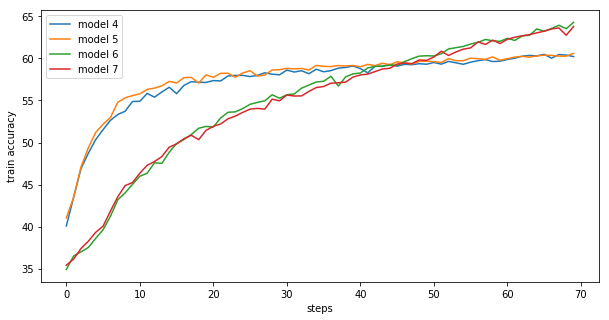

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(10,5)

plt.plot(train_acc4, label="model 4")
plt.plot(train_acc5, label="model 5")
plt.plot(train_acc6, label="model 6")
plt.plot(train_acc7, label="model 7")
plt.xlabel("steps")
plt.ylabel("train accuracy")
plt.legend(loc = 'best')
plt.show()

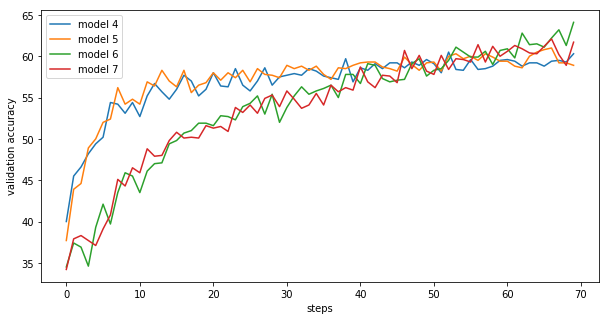

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(10,5)

plt.plot(val_acc4, label="model 4")
plt.plot(val_acc5, label="model 5")
plt.plot(val_acc6, label="model 6")
plt.plot(val_acc7, label="model 7")
plt.xlabel("steps")
plt.ylabel("validation accuracy")
plt.legend(loc = 'best')
plt.show()

In [25]:
# Get the 3 incorrect predictions and 3 correct predictions

BATCH_SIZE = 1
val_dataset2 = VocabDataset(val_data, val_label)
val_loader2 = torch.utils.data.DataLoader(dataset=val_dataset2, 
                                         batch_size=BATCH_SIZE, 
                                         collate_fn=vocab_collate_func, 
                                         shuffle=True)

y2label = {0:'neutral', 1:'entailment', 2:'contradiction'}

def get_incorrect(loader, model):
    correct = 0
    total = 0
    model.eval()
    i = 0
    incorr_data = []
    for data, lengths, labels in loader:
        if i < 3:
            outputs = F.softmax(model(data, lengths), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]
            
            if predicted.eq(labels.view_as(predicted)).sum().item() == 0:                
                i += 1
                for t in data[0]:
                    s = ''
                    for w in t:
                        if w == 0: break
                        w = w.item()
                        s += idx2words[w] + ' '
                    print(s)
                print("The predicted label is {}".format(y2label[predicted.item()]))
                print("The true label is {}".format(y2label[labels.view_as(predicted).item()]))
                print()
    return

print("Get 3 incorrect predictions: ")
get_incorrect(val_loader2, model6)

def get_correct(loader, model):
    correct = 0
    total = 0
    model.eval()
    i = 0
    incorr_data = []
    for data, lengths, labels in loader:
        if i < 3:
            outputs = F.softmax(model(data, lengths), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]
            
            if predicted.eq(labels.view_as(predicted)).sum().item() == 1:                
                i += 1
                for t in data[0]:
                    s = ''
                    for w in t:
                        if w == 0: break
                        w = w.item()
                        s += idx2words[w] + ' '
                    print(s)
                print("The label is {}".format(y2label[predicted.item()]))
                print()
    return

print("Get 3 correct predictions: ")
get_correct(val_loader2, model6)

Get 3 incorrect predictions: 
A kid in a red and black coat is laying on his back in the snow with his arm in the air and a red sled is next to him . 
It is a cold day . 
The predicted label is neutral
The true label is entailment

A man who has a gray beard and gray hair laughs while wearing a purple shirt . 
A man is laughing at a woman who has fallen over . 
The predicted label is contradiction
The true label is neutral

A waitress is serving customers at a restaurant . 
The waitress is sitting in a chair ignoring the customers around her . 
The predicted label is neutral
The true label is contradiction

Get 3 correct predictions: 
A man is photographing a small staked camel and a woman is trying to walk past it . 
A man and a woman are riding a camel . 
The label is contradiction

A band performing on the corner of the street . 
The band is performing outdoors . 
The label is entailment

Two Asian women talking and having drinks at a small round table . 
Two ladies are sitting toge

## Test with mnli data

In [26]:
# load mnli val data
mnli_val = pd.read_csv("mnli_val.tsv", sep='\t')
mnli_val.loc[mnli_val['label'] == 'neutral', 'y'] = 0
mnli_val.loc[mnli_val['label'] == 'entailment', 'y'] = 1
mnli_val.loc[mnli_val['label'] == 'contradiction', 'y'] = 2
mnli_val.head()

,sentence1,sentence2,label,genre,y
0,"'Not entirely , ' I snapped , harsher than int...",I spoke more harshly than I wanted to .,entailment,fiction,1.0
1,cook and then the next time it would be my tur...,I would cook and then the next turn would be h...,contradiction,telephone,2.0
2,The disorder hardly seemed to exist before the...,The disorder did n't seem to be as common when...,entailment,slate,1.0
3,"The Report and Order , in large part , adopts ...",The Report and Order ignores recommendations f...,contradiction,government,2.0
4,"IDPA 's OIG 's mission is to prevent , detect ...",IDPA 's OIG 's mission is clear and cares abou...,entailment,government,1.0


In [27]:
mnli_val['genre'].value_counts()

government    1016
telephone     1005
slate         1002
fiction        995
travel         982
Name: genre, dtype: int64

In [29]:
government = mnli_val.loc[mnli_val['genre'] == 'government']
gov_data = np.array([token2index_dataset(government['sentence1'].tolist()), token2index_dataset(government['sentence2'].tolist())]).transpose()
gov_label = government['y'].tolist()
gov_dataset = VocabDataset(gov_data, gov_label)
gov_loader = torch.utils.data.DataLoader(dataset=gov_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=vocab_collate_func, 
                                           shuffle=True)
print(test_model(gov_loader, model6))

39.960629921259844


In [30]:
telephone = mnli_val.loc[mnli_val['genre'] == 'telephone']
tel_data = np.array([token2index_dataset(telephone['sentence1'].tolist()), token2index_dataset(telephone['sentence2'].tolist())]).transpose()
tel_label = telephone['y'].tolist()
tel_dataset = VocabDataset(tel_data, tel_label)
tel_loader = torch.utils.data.DataLoader(dataset=tel_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=vocab_collate_func, 
                                           shuffle=True)
print(test_model(tel_loader, model6))

39.50248756218905


In [31]:
slate = mnli_val.loc[mnli_val['genre'] == 'slate']
slate_data = np.array([token2index_dataset(slate['sentence1'].tolist()), token2index_dataset(slate['sentence2'].tolist())]).transpose()
slate_label = slate['y'].tolist()
slate_dataset = VocabDataset(slate_data, slate_label)
slate_loader = torch.utils.data.DataLoader(dataset=slate_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=vocab_collate_func, 
                                           shuffle=True)
print(test_model(slate_loader, model6))

37.724550898203596


In [32]:
fiction = mnli_val.loc[mnli_val['genre'] == 'fiction']
fic_data = np.array([token2index_dataset(fiction['sentence1'].tolist()), token2index_dataset(fiction['sentence2'].tolist())]).transpose()
fic_label = fiction['y'].tolist()
fic_dataset = VocabDataset(fic_data, fic_label)
fic_loader = torch.utils.data.DataLoader(dataset=fic_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=vocab_collate_func, 
                                           shuffle=True)
print(test_model(fic_loader, model6))

41.20603015075377


In [33]:
travel = mnli_val.loc[mnli_val['genre'] == 'travel']
tvl_data = np.array([token2index_dataset(travel['sentence1'].tolist()), token2index_dataset(travel['sentence2'].tolist())]).transpose()
tvl_label = travel['y'].tolist()
tvl_dataset = VocabDataset(tvl_data, tvl_label)
tvl_loader = torch.utils.data.DataLoader(dataset=tvl_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=vocab_collate_func, 
                                           shuffle=True)
print(test_model(fic_loader, model6))

39.19597989949749
